In [1]:
!pip install pytorch-tabnet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import torch
from xgboost import XGBRegressor, plot_importance


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Load CSV file
file_path = "/Users/saipavanrevooru/WorkSpace/Projects/SCPP/StaticCodePowerPredictor/output/power_dataset_may_10.csv"  # Update with your file path
df = pd.read_csv(file_path)

In [3]:
df["power_mw"] = df["power_mw"].round().astype(int)

In [4]:
df.head()

,num_functions,cyclomatic_complexity,num_loops,num_function_calls,num_memory_allocations,num_pointer_operations,num_exp_math_operations,instruction_count,arithmetic_instr_pct,memory_instr_pct,control_instr_pct,control_path_depth,power_mw
0,165086,63832,52474,105374,8674,9,13908,2845738,0.49,0.30,2.24,2,172
1,162148,68968,46618,107695,5034,9,22004,2562108,0.86,0.20,2.69,2,114
2,206826,110113,70865,169463,38536,9,56532,3324007,1.70,1.16,3.31,2,372
3,154102,87651,63253,135325,39946,9,54706,3112872,1.76,1.28,2.82,2,424
4,205951,90197,71459,168132,19588,9,56270,3608723,1.56,0.54,2.50,2,234


In [5]:
# Display basic info
print("Original DataFrame:")
print(df.info())
print(df.describe())

Original DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_functions            2345 non-null   int64  
 1   cyclomatic_complexity    2345 non-null   int64  
 2   num_loops                2345 non-null   int64  
 3   num_function_calls       2345 non-null   int64  
 4   num_memory_allocations   2345 non-null   int64  
 5   num_pointer_operations   2345 non-null   int64  
 6   num_exp_math_operations  2345 non-null   int64  
 7   instruction_count        2345 non-null   int64  
 8   arithmetic_instr_pct     2345 non-null   float64
 9   memory_instr_pct         2345 non-null   float64
 10  control_instr_pct        2345 non-null   float64
 11  control_path_depth       2345 non-null   int64  
 12  power_mw                 2345 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 238.3 KB
None
     

In [6]:
# 1. Remove duplicate rows
df = df.drop_duplicates()

# 2. Handle missing values
df = df.dropna()  # Drop rows with missing values (alternative: fill with mean/median)

In [7]:
# 3. Ensure correct data types
for col in df.select_dtypes(include=['object']).columns:
    try:
        df[col] = pd.to_numeric(df[col], errors='ignore')  # Convert numerical strings to numbers
    except:
        pass

/var/folders/0w/d6mg_1rx63jcpkq1mfpclt980000gn/T/ipykernel_6543/1328651030.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


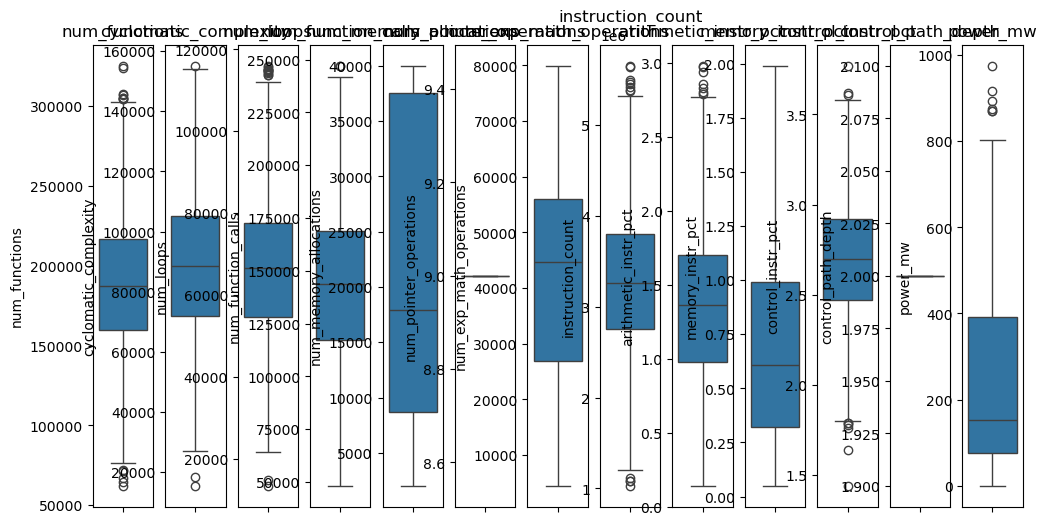

In [8]:
# 4. Visualize outliers before removal
numeric_cols = df.select_dtypes(include=['number']).columns
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [9]:
# Aggressive IQR filtering
df_cleaned = df.copy()
for col in df.columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1 * IQR  # More aggressive (default is 1.5)
    upper_bound = Q3 + 1 * IQR
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]

In [10]:
# scaler = RobustScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)

In [11]:
# joblib.dump(scaler, "scaler.pkl")

In [12]:
# df_scaled = df_scaled.drop(columns=["num_pointer_operations"])

/var/folders/0w/d6mg_1rx63jcpkq1mfpclt980000gn/T/ipykernel_6543/232143039.py:8: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


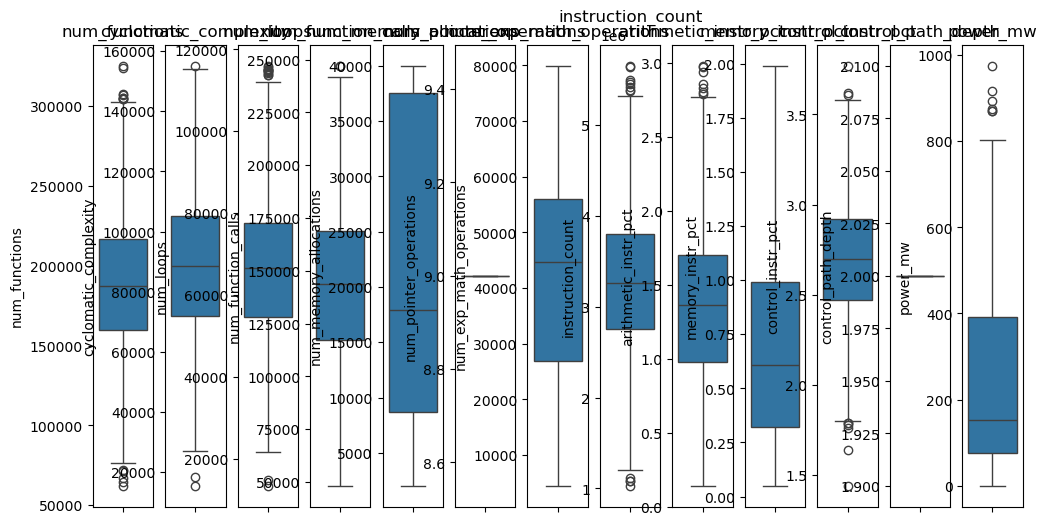

In [13]:
# 4. Visualize outliers after removal
numeric_cols = df_cleaned.select_dtypes(include=['number']).columns
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [14]:
# Display basic info
print("Cleaned DataFrame:")
print(df_cleaned.info())
print(df_cleaned.describe())

Cleaned DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 2023 entries, 0 to 2344
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_functions            2023 non-null   int64  
 1   cyclomatic_complexity    2023 non-null   int64  
 2   num_loops                2023 non-null   int64  
 3   num_function_calls       2023 non-null   int64  
 4   num_memory_allocations   2023 non-null   int64  
 5   num_pointer_operations   2023 non-null   int64  
 6   num_exp_math_operations  2023 non-null   int64  
 7   instruction_count        2023 non-null   int64  
 8   arithmetic_instr_pct     2023 non-null   float64
 9   memory_instr_pct         2023 non-null   float64
 10  control_instr_pct        2023 non-null   float64
 11  control_path_depth       2023 non-null   int64  
 12  power_mw                 2023 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 221.3 KB
None
       num_

In [15]:
df_cleaned.corr()

,num_functions,cyclomatic_complexity,num_loops,num_function_calls,num_memory_allocations,num_pointer_operations,num_exp_math_operations,instruction_count,arithmetic_instr_pct,memory_instr_pct,control_instr_pct,control_path_depth,power_mw
num_functions,1.000000,0.698102,0.731392,0.860417,0.308820,NaN,0.422545,0.887202,0.031696,0.048389,-0.076147,NaN,0.284491
cyclomatic_complexity,0.698102,1.000000,0.921102,0.713359,0.560118,NaN,0.561968,0.887606,0.188279,0.318918,0.561504,NaN,0.495806
num_loops,0.731392,0.921102,1.000000,0.703530,0.358265,NaN,0.519019,0.927282,0.122028,0.088701,0.325991,NaN,0.326767
num_function_calls,0.860417,0.713359,0.703530,1.000000,0.575617,NaN,0.818457,0.840656,0.522166,0.349436,0.031253,NaN,0.502698
num_memory_allocations,0.308820,0.560118,0.358265,0.575617,1.000000,NaN,0.689259,0.438523,0.571247,0.941605,0.413647,NaN,0.829958
num_pointer_operations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_exp_math_operations,0.422545,0.561968,0.519019,0.818457,0.689259,NaN,1.000000,0.562408,0.881253,0.560441,0.193717,NaN,0.586812
instruction_count,0.887202,0.887606,0.927282,0.840656,0.438523,NaN,0.562408,1.000000,0.135288,0.152475,0.126782,NaN,0.394911
arithmetic_instr_pct,0.031696,0.188279,0.122028,0.522166,0.571247,NaN,0.881253,0.135288,1.000000,0.585803,0.151996,NaN,0.470084
memory_instr_pct,0.048389,0.318918,0.088701,0.349436,0.941605,NaN,0.560441,0.152475,0.585803,1.000000,0.415850,NaN,0.760222


In [16]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import optuna
# from sklearn.model_selection import KFold, train_test_split, GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge
# from catboost import CatBoostRegressor, Pool
# import xgboost as xgb

# X = df_scaled.drop(columns=['power_mw'])
# y = df_scaled['power_mw'].values

# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# xgb_mse_list, tabnet_mse_list, ensemble_mse_list, stack_mse_list = [], [], [], []
# xgb_r2_list, tabnet_r2_list, ensemble_r2_list, stack_r2_list = [], [], [], []

# # Optuna XGBoost Tuning
# def xgb_objective(trial):
#     params = {
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "max_depth": trial.suggest_int("max_depth", 3, 10),
#         "subsample": trial.suggest_float("subsample", 0.6, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#         "n_estimators": 100,
#         "objective": "reg:squarederror",
#         "eval_metric": "rmse"
#     }
#     scores = []
#     for train_idx, val_idx in kf.split(X):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]
#         model = xgb.XGBRegressor(**params)
#         model.fit(X_train, y_train)
#         preds = model.predict(X_val)
#         scores.append(mean_squared_error(y_val, preds))
#     return np.mean(scores)

# xgb_study = optuna.create_study(direction="minimize")
# xgb_study.optimize(xgb_objective, n_trials=20)
# best_xgb_params = xgb_study.best_params
# print("Best XGBoost Parameters:", best_xgb_params)

# # Optuna CatBoost Tuning
# def catboost_objective(trial):
#     params = {
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
#         'iterations': 100,
#         'loss_function': 'RMSE',
#         'verbose': 0
#     }
#     scores = []
#     for train_idx, val_idx in kf.split(X):
#         X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#         y_train, y_val = y[train_idx], y[val_idx]
#         model = CatBoostRegressor(**params)
#         model.fit(X_train, y_train)
#         preds = model.predict(X_val)
#         scores.append(mean_squared_error(y_val, preds))
#     return np.mean(scores)

# cat_study = optuna.create_study(direction="minimize")
# cat_study.optimize(catboost_objective, n_trials=20)
# best_cat_params = cat_study.best_params
# print("Best CatBoost Parameters:", best_cat_params)

# # Final Evaluation
# for train_idx, val_idx in kf.split(X):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     # XGBoost
#     xgb_model = xgb.XGBRegressor(**best_xgb_params)
#     xgb_model.fit(X_train, y_train)
#     y_pred_xgb = xgb_model.predict(X_val)

#     # CatBoost
#     cat_model = CatBoostRegressor(**best_cat_params, verbose=0)
#     cat_model.fit(X_train, y_train)
#     y_pred_cat = cat_model.predict(X_val)

#     # Weighted Ensemble
#     alpha = 0.7
#     beta = 0.3
#     y_pred_ensemble = (alpha * y_pred_xgb) + (beta * y_pred_cat)

#     # Stacking Ensemble
#     stack_model = StackingRegressor(
#         estimators=[
#             ('xgb', xgb_model),
#             ('cat', cat_model)
#         ],
#         final_estimator=Ridge()
#     )
#     stack_model.fit(X_train, y_train)
#     y_pred_stack = stack_model.predict(X_val)

#     # Metrics
#     xgb_mse_list.append(mean_squared_error(y_val, y_pred_xgb))
#     tabnet_mse_list.append(mean_squared_error(y_val, y_pred_cat))
#     ensemble_mse_list.append(mean_squared_error(y_val, y_pred_ensemble))
#     stack_mse_list.append(mean_squared_error(y_val, y_pred_stack))

#     xgb_r2_list.append(r2_score(y_val, y_pred_xgb))
#     tabnet_r2_list.append(r2_score(y_val, y_pred_cat))
#     ensemble_r2_list.append(r2_score(y_val, y_pred_ensemble))
#     stack_r2_list.append(r2_score(y_val, y_pred_stack))

#     # Plotting
#     plt.figure(figsize=(10, 6))
#     plt.scatter(y_val, y_pred_stack, alpha=0.5, color='blue', label="Stacked Predictions")
#     max_val = max(max(y_val), max(y_pred_stack))
#     plt.plot([0, max_val], [0, max_val], linestyle='--', color='red', label="Ideal Line")
#     plt.xlabel("Actual Power (mW)")
#     plt.ylabel("Predicted Power (mW)")
#     plt.title("Actual vs Stacked Predicted Power Consumption")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

# # Summary
# print(f"XGBoost Avg MSE: {np.mean(xgb_mse_list):.4f} ± {np.std(xgb_mse_list):.4f} | R²: {np.mean(xgb_r2_list):.4f}")
# print(f"CatBoost Avg MSE: {np.mean(tabnet_mse_list):.4f} ± {np.std(tabnet_mse_list):.4f} | R²: {np.mean(tabnet_r2_list):.4f}")
# print(f"Ensemble Avg MSE: {np.mean(ensemble_mse_list):.4f} ± {np.std(ensemble_mse_list):.4f} | R²: {np.mean(ensemble_r2_list):.4f}")
# print(f"Stacked Avg MSE: {np.mean(stack_mse_list):.4f} ± {np.std(stack_mse_list):.4f} | R²: {np.mean(stack_r2_list):.4f}")


In [17]:
# Display basic info
print("Cleaned DataFrame:")
print(df_cleaned.info())
print(df_cleaned.describe())

Cleaned DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 2023 entries, 0 to 2344
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_functions            2023 non-null   int64  
 1   cyclomatic_complexity    2023 non-null   int64  
 2   num_loops                2023 non-null   int64  
 3   num_function_calls       2023 non-null   int64  
 4   num_memory_allocations   2023 non-null   int64  
 5   num_pointer_operations   2023 non-null   int64  
 6   num_exp_math_operations  2023 non-null   int64  
 7   instruction_count        2023 non-null   int64  
 8   arithmetic_instr_pct     2023 non-null   float64
 9   memory_instr_pct         2023 non-null   float64
 10  control_instr_pct        2023 non-null   float64
 11  control_path_depth       2023 non-null   int64  
 12  power_mw                 2023 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 221.3 KB
None
       num_

Best XGBoost Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:38:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


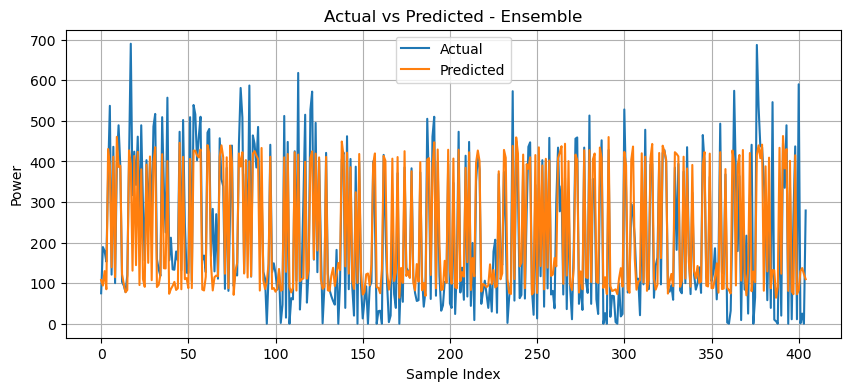

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:39:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


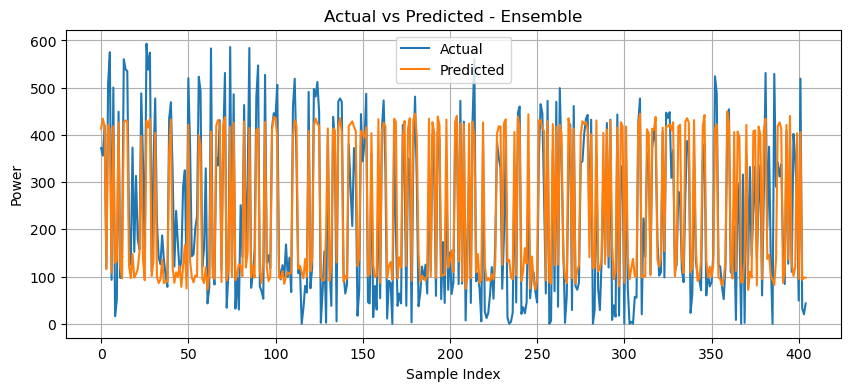

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:39:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


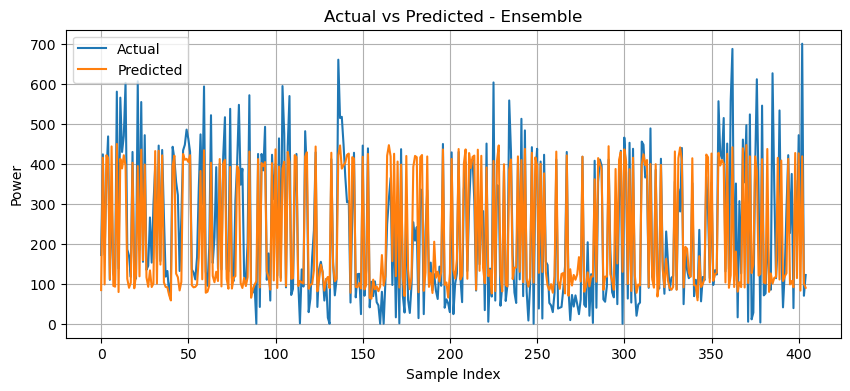

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:40:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


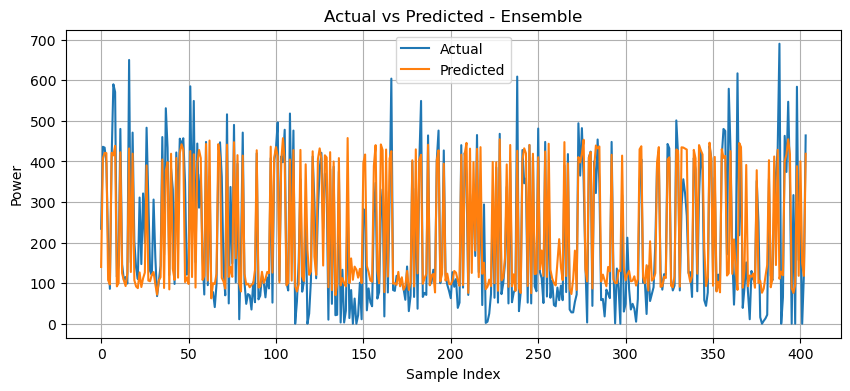

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


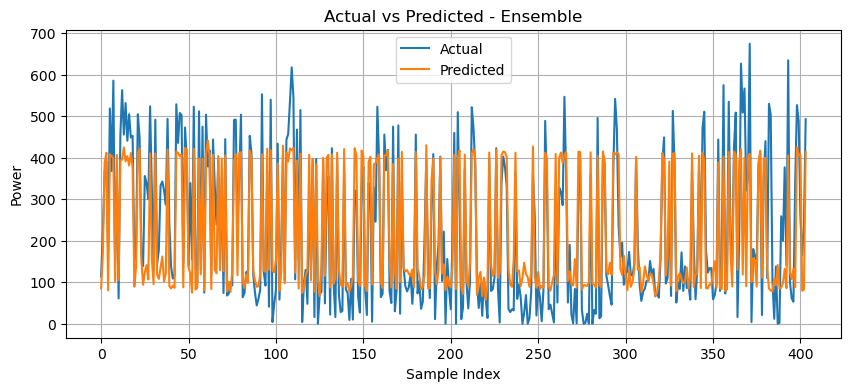


====== FINAL METRICS ======
XGBoost    -> MSE: 8271.63 ± 521.14, MAE: 66.47, R²: 0.7271
TabNet     -> MSE: 8257.72 ± 613.75, MAE: 66.13, R²: 0.7276
MLP        -> MSE: 8532.12 ± 702.36, MAE: 67.39, R²: 0.7186
Ensemble   -> MSE: 8185.48 ± 603.32, MAE: 65.84, R²: 0.7300

Ensemble Mean Absolute Percentage Error (MAPE): 9329239089592612.00%


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Feature-target split
X_raw = df_cleaned.iloc[:, :-1].values
y_raw = df_cleaned.iloc[:, -1].values.reshape(-1, 1)

# Scale features and target
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X = X_scaler.fit_transform(X_raw)
y = y_scaler.fit_transform(y_raw).flatten()

# K-Fold setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Metric storage
xgb_mse_list, tabnet_mse_list, mlp_mse_list, ensemble_mse_list = [], [], [], []
xgb_mae_list, tabnet_mae_list, mlp_mae_list, ensemble_mae_list = [], [], [], []
xgb_r2_list, tabnet_r2_list, mlp_r2_list, ensemble_r2_list = [], [], [], []

# XGBoost Grid Search (run once)
xgb_model_for_grid = xgb.XGBRegressor()
xgb_param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5, 6, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "n_estimators": [100, 200, 300],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.3]
}
xgb_grid = GridSearchCV(estimator=xgb_model_for_grid, param_grid=xgb_param_grid, cv=3, scoring='neg_mean_squared_error', verbose=0)
xgb_grid.fit(X, y)
best_xgb_params = xgb_grid.best_params_
print("Best XGBoost Parameters:", best_xgb_params)

all_actual_values, all_predicted_values = [], []

# Cross-validation
for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    xgb_model = xgb.train(best_xgb_params, dtrain, num_boost_round=100)
    y_pred_xgb_scaled = xgb_model.predict(dval)

    # TabNet
    tabnet_model = TabNetRegressor(
        n_d=16, n_a=16, n_steps=3, gamma=1.5, lambda_sparse=1e-4, momentum=0.3, verbose=0
    )
    tabnet_model.fit(X_train, y_train.reshape(-1, 1),
                     max_epochs=500, patience=10,
                     batch_size=128, virtual_batch_size=64)
    y_pred_tabnet_scaled = tabnet_model.predict(X_val).flatten()

    # MLP
    mlp_model = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=500, random_state=42)
    mlp_model.fit(X_train, y_train)
    y_pred_mlp_scaled = mlp_model.predict(X_val)

    # Ensemble Prediction
    alpha, beta, gamma = 0.4, 0.3, 0.3
    y_pred_ensemble_scaled = (alpha * y_pred_xgb_scaled +
                              beta * y_pred_tabnet_scaled +
                              gamma * y_pred_mlp_scaled)

    # Inverse transform predictions and labels
    y_val_actual = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
    y_pred_xgb_actual = y_scaler.inverse_transform(y_pred_xgb_scaled.reshape(-1, 1)).flatten()
    y_pred_tabnet_actual = y_scaler.inverse_transform(y_pred_tabnet_scaled.reshape(-1, 1)).flatten()
    y_pred_mlp_actual = y_scaler.inverse_transform(y_pred_mlp_scaled.reshape(-1, 1)).flatten()
    y_pred_ensemble_actual = y_scaler.inverse_transform(y_pred_ensemble_scaled.reshape(-1, 1)).flatten()

    # Metrics
    for model_name, pred, mse_list, mae_list, r2_list in zip(
        ["XGB", "TabNet", "MLP", "Ensemble"],
        [y_pred_xgb_actual, y_pred_tabnet_actual, y_pred_mlp_actual, y_pred_ensemble_actual],
        [xgb_mse_list, tabnet_mse_list, mlp_mse_list, ensemble_mse_list],
        [xgb_mae_list, tabnet_mae_list, mlp_mae_list, ensemble_mae_list],
        [xgb_r2_list, tabnet_r2_list, mlp_r2_list, ensemble_r2_list]
    ):
        mse_list.append(mean_squared_error(y_val_actual, pred))
        mae_list.append(mean_absolute_error(y_val_actual, pred))
        r2_list.append(r2_score(y_val_actual, pred))

    # For final MAPE
    all_actual_values.extend(y_val_actual)
    all_predicted_values.extend(y_pred_ensemble_actual)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(y_val_actual, label='Actual')
    plt.plot(y_pred_ensemble_actual, label='Predicted')
    plt.title('Actual vs Predicted - Ensemble')
    plt.xlabel('Sample Index')
    plt.ylabel('Power')
    plt.legend()
    plt.grid(True)
    plt.show()

# Final results
print("\n====== FINAL METRICS ======")
def print_metrics(name, mse, mae, r2):
    print(f"{name:10} -> MSE: {np.mean(mse):.2f} ± {np.std(mse):.2f}, "
          f"MAE: {np.mean(mae):.2f}, R²: {np.mean(r2):.4f}")

print_metrics("XGBoost", xgb_mse_list, xgb_mae_list, xgb_r2_list)
print_metrics("TabNet", tabnet_mse_list, tabnet_mae_list, tabnet_r2_list)
print_metrics("MLP", mlp_mse_list, mlp_mae_list, mlp_r2_list)
print_metrics("Ensemble", ensemble_mse_list, ensemble_mae_list, ensemble_r2_list)

# MAPE
mape = mean_absolute_percentage_error(all_actual_values, all_predicted_values) * 100
print(f"\nEnsemble Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

In [47]:
# Filter out near-zero true values to prevent division by zero in MAPE
all_actual_values = np.array(all_actual_values)
all_predicted_values = np.array(all_predicted_values)

valid_indices = np.where(np.abs(all_actual_values) > 1e-3)[0]
filtered_actuals = all_actual_values[valid_indices]
filtered_predictions = all_predicted_values[valid_indices]

mape = mean_absolute_percentage_error(filtered_actuals, filtered_predictions) * 100
print(f"\nEnsemble Mean Absolute Percentage Error (Filtered MAPE): {mape:.2f}%")


Ensemble Mean Absolute Percentage Error (Filtered MAPE): 158.95%


In [45]:
print(all_actual_values[:10])
print(all_predicted_values[:10])

[75.0, 189.0, 179.0, 153.0, 366.0, 537.0, 121.0, 436.0, 99.99999999999999, 392.0]
[107.68261595557759, 94.0200841804012, 129.69067138202868, 84.9871588102333, 430.5038621048505, 390.16600569938214, 139.01645123922992, 411.52348006587005, 114.62761693642284, 460.558992816382]


In [20]:
tabnet_model.save_model("trained_models/tabnet_model")
xgb_model.save_model("trained_models/xgb_model.json")

Successfully saved model at trained_models/tabnet_model.zip


In [21]:
# for train_idx, val_idx in kf.split(X):
#     X_train, X_val = X[train_idx], X[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     # Train XGBoost
#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dval = xgb.DMatrix(X_val, label=y_val)

#     xgb_params = {
#         "objective": "reg:squarederror",
#         "eval_metric": "rmse",
#         "learning_rate": 0.05,
#         "max_depth": 6,
#         "subsample": 0.8,
#         "colsample_bytree": 0.8,
#     }
#     xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100)
#     y_pred_xgb = xgb_model.predict(dval)

#     # Train Pretrained TabNet Model
#     tabnet_model = TabNetRegressor(verbose=0)
#     tabnet_model.fit(X_train, y_train.reshape(-1, 1), max_epochs=100, patience=10, batch_size=128, virtual_batch_size=32)

#     y_pred_tabnet = tabnet_model.predict(X_val).flatten()

#     # Weighted Ensemble Prediction
#     alpha = 0.7  # XGBoost weight
#     beta = 0.3   # TabNet weight
#     y_pred_final = (alpha * y_pred_xgb) + (beta * y_pred_tabnet)

#     # Evaluate Performance
#     mse_xgb = mean_squared_error(y_val, y_pred_xgb)
#     mse_tabnet = mean_squared_error(y_val, y_pred_tabnet)
#     mse_final = mean_squared_error(y_val, y_pred_final)

#     xgb_mse_list.append(mse_xgb)
#     tabnet_mse_list.append(mse_tabnet)
#     ensemble_mse_list.append(mse_final)

#     plt.figure(figsize=(10, 6))

#     # Scatter plot: Actual vs Predicted
#     plt.scatter(y_val, y_pred_final, alpha=0.5, color='blue', label="Predicted vs Actual")
    
#     # Reference line (Perfect Predictions)
#     max_val = max(max(y_val), max(y_pred_final))
#     plt.plot([0, max_val], [0, max_val], linestyle='--', color='red', label="Ideal Prediction Line")
    
#     # Labels and title
#     plt.xlabel("Actual Power (mW)")
#     plt.ylabel("Predicted Power (mW)")
#     plt.title("Actual vs Predicted Power Consumption")
#     plt.legend()
#     plt.grid(True)
    
#     plt.show()

# # Print Cross-Validation Results
# print(f"XGBoost Avg MSE: {np.mean(xgb_mse_list):.4f} ± {np.std(xgb_mse_list):.4f}")
# print(f"TabNet Avg MSE: {np.mean(tabnet_mse_list):.4f} ± {np.std(tabnet_mse_list):.4f}")
# print(f"Ensemble Model Avg MSE: {np.mean(ensemble_mse_list):.4f} ± {np.std(ensemble_mse_list):.4f}")